In [84]:
import os
import requests
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.mosaicplot import mosaic
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import pairwise_distances


In [85]:
#looking into the dataframe

mcdonalds = pd.read_csv("mcdonalds.csv") 
print(mcdonalds.columns)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')


In [86]:
print(mcdonalds.shape)

(1453, 15)


In [87]:
print(mcdonalds.head(3))

  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [88]:
mcdonalds.describe()

,Age
count,1453.000000
mean,44.604955
std,14.221178
min,18.000000
25%,33.000000
50%,45.000000
75%,57.000000
max,71.000000


In [89]:
# Converting  'Yes'/'No' responses to binary 1/0
MD_x = mcdonalds.iloc[:, :11].map(lambda x: 1 if x == "Yes" else 0)
col_means = MD_x.mean().round(2)
print(col_means)


yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [90]:

# dataframe to calculate pca,std and cumproportion
from sklearn.decomposition import PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

pcasum_df = pd.DataFrame({
    "Principal Component": range(1, len(pca.explained_variance_) + 1),
    "Standard Deviation": pca.explained_variance_,
    "Proportion of Variance": pca.explained_variance_ratio_,
})

pcasum_df["Cumulative Proportion"] = pcasum_df["Proportion of Variance"].cumsum()

pcasum_df = pcasum_df[['Principal Component', 'Standard Deviation',  'Cumulative Proportion','Proportion of Variance',]]

print("Pca Summary:")
print(pcasum_df)

Pca Summary:
    Principal Component  Standard Deviation  Cumulative Proportion  \
0                     1            0.573124               0.299447   
1                     2            0.369002               0.492244   
2                     3            0.254641               0.625290   
3                     4            0.159040               0.708386   
4                     5            0.113842               0.767866   
5                     6            0.096270               0.818166   
6                     7            0.083925               0.862015   
7                     8            0.075692               0.901563   
8                     9            0.070358               0.938323   
9                    10            0.061922               0.970677   
10                   11            0.056123               1.000000   

    Proportion of Variance  
0                 0.299447  
1                 0.192797  
2                 0.133045  
3                 0.083096  
4

In [91]:
#pca of various categories decomposed together
decomposed_df = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

decomposed_df.index = MD_x.columns

with pd.option_context('display.float_format', '{:.2f}'.format):
    print("PCA decomposed:")
    print(decomposed_df)

PCA decomposed:
             PC1   PC2   PC3   PC4   PC5   PC6   PC7   PC8   PC9  PC10  PC11
yummy       0.48 -0.36  0.30  0.06  0.31 -0.17 -0.28 -0.01 -0.57  0.11 -0.05
convenient  0.16 -0.02  0.06 -0.14 -0.28  0.35 -0.06  0.11  0.02  0.67  0.54
spicy       0.01 -0.02  0.04  0.20 -0.07  0.36  0.71 -0.38 -0.40  0.08 -0.14
fattening  -0.12  0.03  0.32 -0.35  0.07  0.41 -0.39 -0.59  0.16  0.01 -0.25
greasy     -0.30  0.06  0.80  0.25 -0.36 -0.21  0.04  0.14  0.00 -0.01 -0.00
fast        0.11  0.09  0.06 -0.10 -0.11  0.59 -0.09  0.63 -0.17 -0.24 -0.34
cheap       0.34  0.61  0.15  0.12  0.13  0.10 -0.04 -0.14 -0.08 -0.43  0.49
tasty       0.47 -0.31  0.29 -0.00  0.21  0.08  0.36  0.07  0.64 -0.08 -0.02
expensive  -0.33 -0.60 -0.02  0.07  0.00  0.26 -0.07 -0.03 -0.07 -0.45  0.49
healthy     0.21 -0.08 -0.19  0.76 -0.29  0.18 -0.35 -0.18  0.19  0.04 -0.16
disgusting -0.37  0.14  0.09  0.37  0.73  0.21 -0.03  0.17  0.07  0.29  0.04


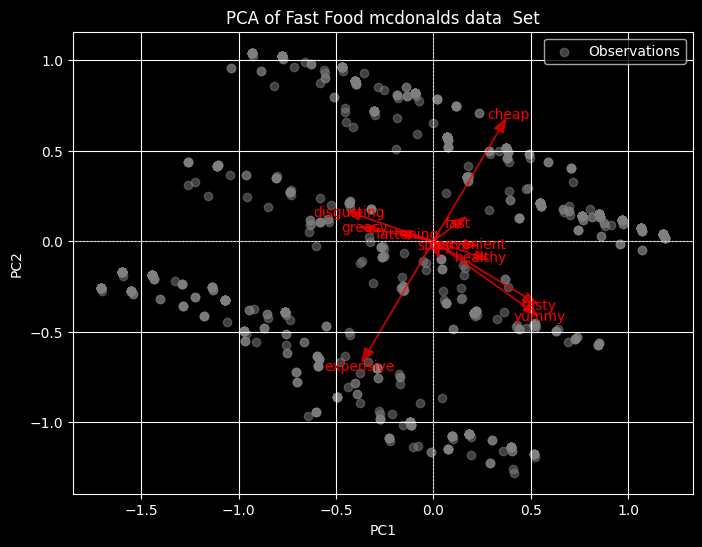

In [92]:
# Fitting the PCA model and obtaining the  scores and scatter_map
pca.fit(MD_x)
scores = pca.transform(MD_x)   
scatter_map = pca.components_.T     
plt.figure(figsize=(8, 6))

# Plot the observations on the first two principal components
plt.scatter(scores[:, 0], scores[:, 1], color='grey', alpha=0.5, label='Observations')
for i in range(scatter_map.shape[0]):
    plt.arrow(0, 0, scatter_map[i, 0], scatter_map[i, 1], color='red', alpha=0.7, head_width=0.05)
    plt.text(scatter_map[i, 0] * 1.15, scatter_map[i, 1] * 1.15, mcdonalds.columns[i], color='red', 
             ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title('PCA of Fast Food mcdonalds data  Set')
plt.grid(True)
plt.legend()
plt.show()


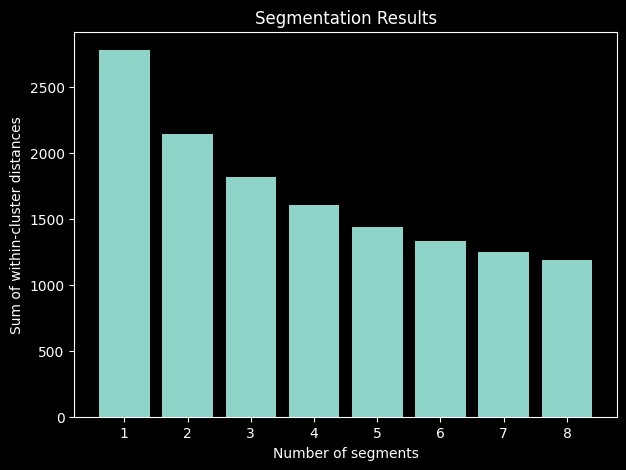

In [93]:
#finding out the best K forr suitable clusters
# Set random seed for reproducibility
np.random.seed(1234)

nrep = 10
num_segments = range(1, 9)
within_cluster_distances = []
MD_k = {}

# Assuming MD is your data (MD_x)
for k in num_segments:
    kmeans = KMeans(n_clusters=k, n_init=nrep, random_state=1234)
    kmeans.fit(MD_x)
    within_cluster_distances.append(kmeans.inertia_)
    MD_k[str(k)] = kmeans

# Plot within-cluster distances
plt.bar(num_segments, within_cluster_distances)
plt.xlabel("Number of segments")
plt.ylabel("Sum of within-cluster distances")
plt.title("Segmentation Results")
plt.show()

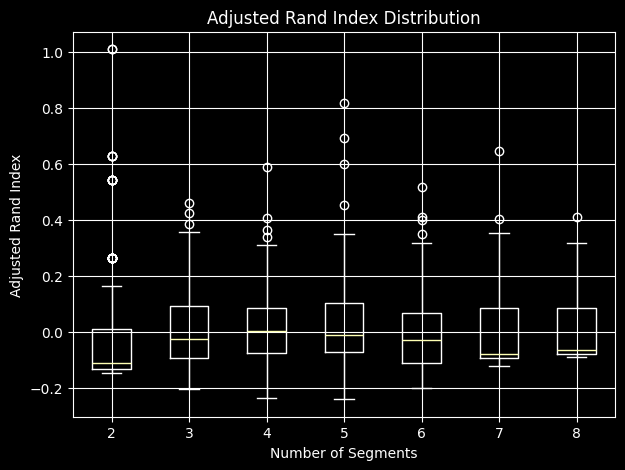

In [94]:
#box plot for global stability of k_means 
boot_n = 200
ARI_scores = []

for label in k_result :
    bootstrap_samples = [np.random.choice(label, size=len(label), replace=True) for _ in range(boot_n)]
    ari_boot = [adjusted_rand_score(label, bootstrap_sample) + 0.01 for bootstrap_sample in bootstrap_samples]
    ARI_scores.append(ari_boot)
plt.boxplot(ARI_scores, tick_labels=range(2, 9))
plt.title('Adjusted Rand Index Distribution')
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.grid(True)
plt.show()

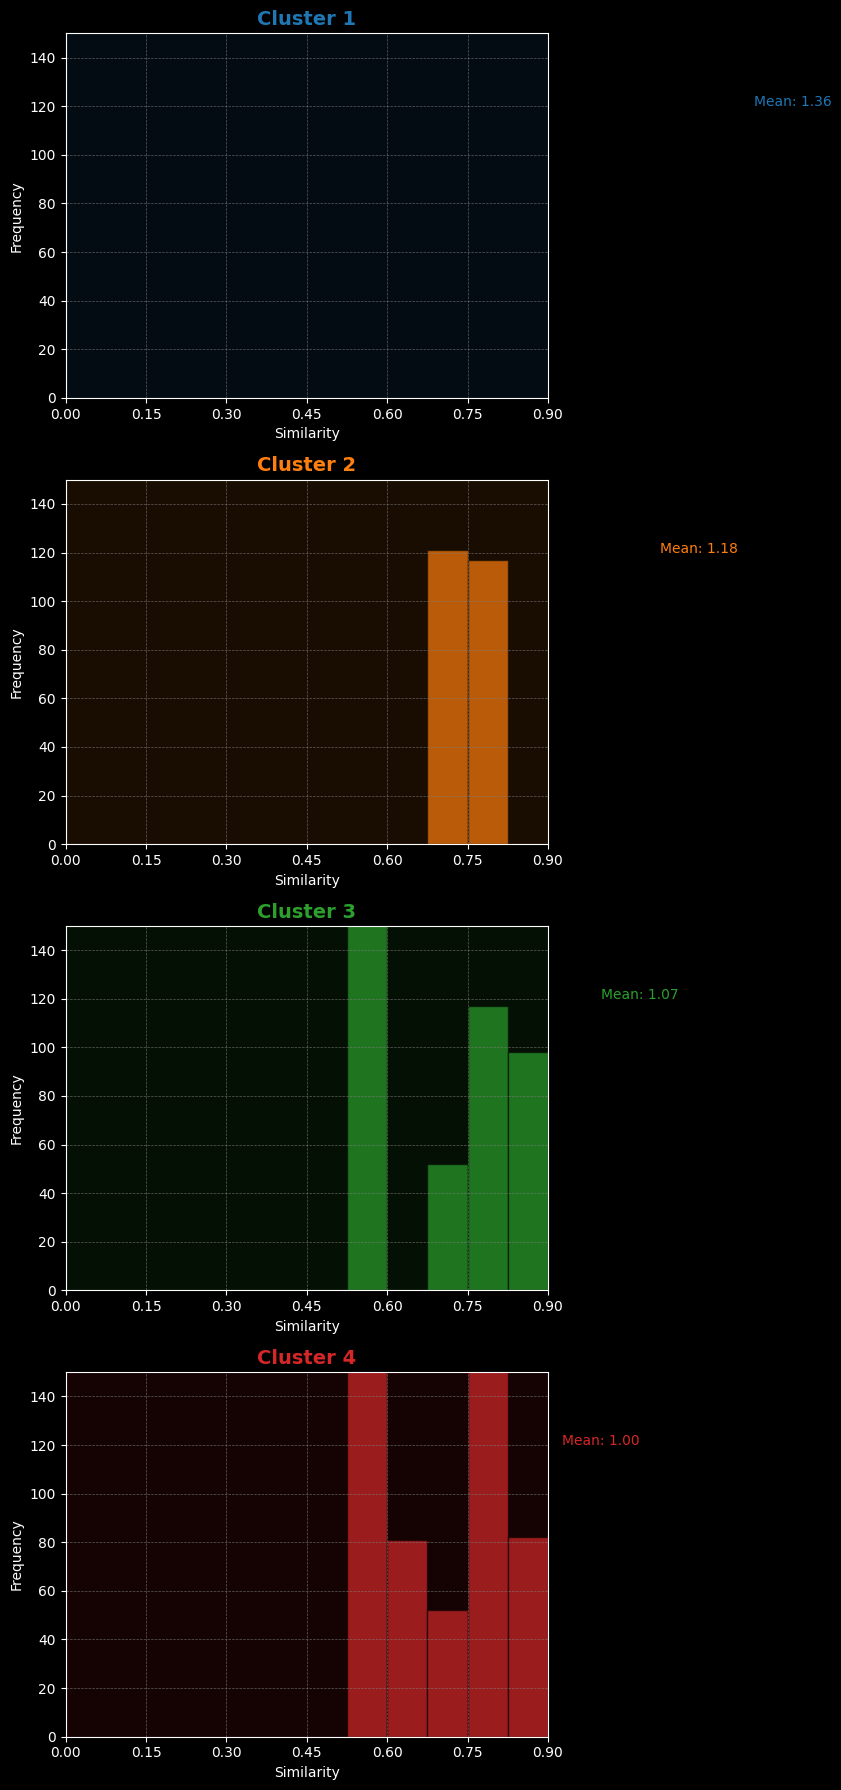

In [95]:
# Updated configuration for histogram plots
similarity_range = (0, 0.9)    # Narrowed range for more focus on lower similarities
bin_count = 12                 # Adjusted bin count for a different look
max_hist_frequency = 150       # Max frequency for y-axis

# Define custom colors for each cluster plot
cluster_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, orange, green, red

# Set up figure with a 4x1 grid of subplots
fig, axes = plt.subplots(4, 1, figsize=(10, 18))  # Increased figure size for emphasis

# Generate histograms for each cluster with distinct style elements
def plot_enhanced_similarity_histograms(data, model_dict, axes_array, bins, range_values, max_freq, colors):
    for cluster_id in range(1, 5):
        # Predict labels and calculate minimum distances
        predicted_labels = model_dict[str(cluster_id)].predict(data)
        min_distances = model_dict[str(cluster_id)].transform(data).min(axis=1)
        
        # Select the appropriate subplot in a 4x1 layout
        ax = axes_array[cluster_id - 1]
        
        # Plot histogram with transparency and unique color for each cluster
        ax.hist(
            min_distances, 
            bins=bins, 
            range=range_values, 
            color=colors[cluster_id - 1], 
            edgecolor='black', 
            alpha=0.7
        )
        
        # Set labels and title
        ax.set_xlabel('Similarity')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Cluster {cluster_id}', fontsize=14, fontweight='bold', color=colors[cluster_id - 1])
        
        # Set limits, grid, and customized tick marks
        ax.set_xlim(range_values)
        ax.set_ylim(0, max_freq)
        ax.set_xticks([0, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
        ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        
        # Highlighting area under the histogram curve
        ax.fill_betweenx(
            y=range(0, max_freq + 1), 
            x1=0, 
            x2=min_distances.mean(), 
            color=colors[cluster_id - 1], 
            alpha=0.1
        )
        
        # Adding annotation for mean similarity
        ax.axvline(x=min_distances.mean(), color=colors[cluster_id - 1], linestyle='--', linewidth=1)
        ax.text(
            min_distances.mean(), max_freq * 0.8, 
            f'Mean: {min_distances.mean():.2f}', 
            color=colors[cluster_id - 1], 
            ha='center'
        )

# Call the enhanced plotting function
plot_enhanced_similarity_histograms(MD_x,MD_k , axes, bin_count, similarity_range, max_hist_frequency, cluster_colors)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


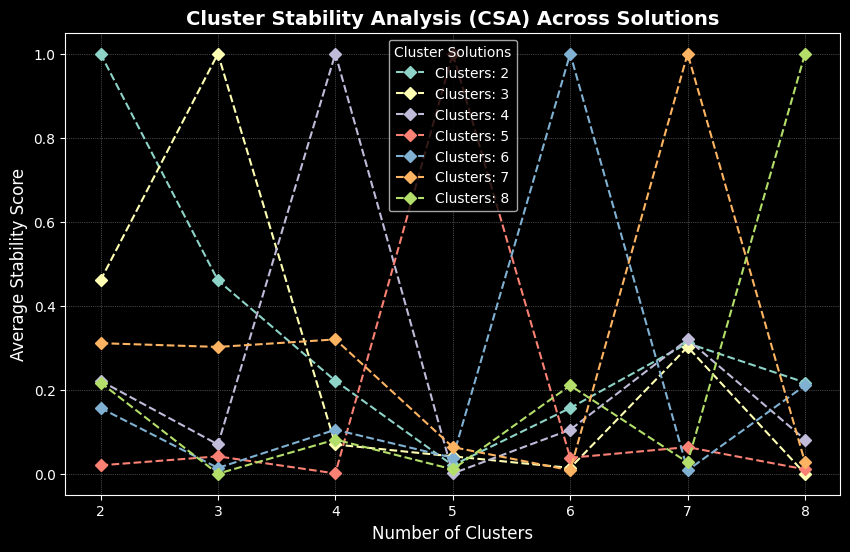

In [96]:
# Updated segment range and Segment level stability across solutions
n_clusters_range = range(2, 9)
stability_scores = []

# Calculating stability for each clustering solutions
for n_clusters in n_clusters_range:
    cluster_labels = MD_k[str(n_clusters)].predict(MD_x)  
    stability_scores.append(cluster_labels)

plt.figure(figsize=(10, 6)) 

for idx, n_clusters in enumerate(n_clusters_range):
    stability_values = [
        np.mean(stability_scores[idx] == cluster_label_set)
        for cluster_label_set in stability_scores
    ]
    plt.plot(
        n_clusters_range, stability_values, 
        marker='D', linestyle='--', linewidth=1.5, 
        label=f'Clusters: {n_clusters}'
    )

plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Average Stability Score', fontsize=12)
plt.title('Cluster Stability Analysis (CSA) Across Solutions', fontsize=14, fontweight='bold')
plt.xticks(n_clusters_range, fontsize=10)
plt.legend(title="Cluster Solutions")
plt.grid(color='gray', linestyle=':', linewidth=0.5)  

plt.show()


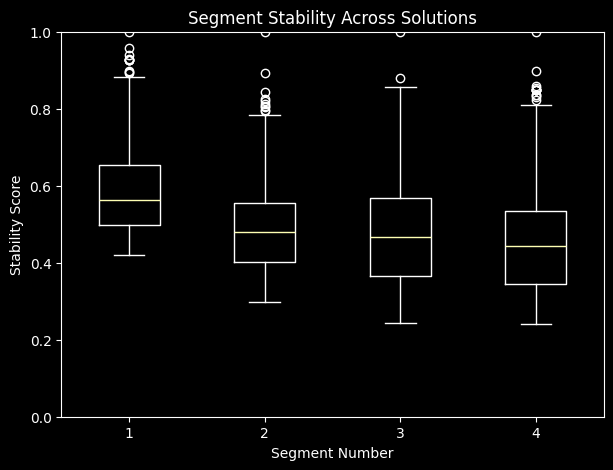

In [97]:
# Defining the  segment level stability within solutions and initialize result storage 
segment_ids = ["1", "2", "3", "4"]
cluster_labels = {}
cluster_distances = {}

# Compute cluster labels and distances for each segment
def compute_cluster_metrics(data, segment_list, model_dict):
    labels, distances = {}, {}
    for seg in segment_list:
        labels[seg] = model_dict[seg].predict(data)
        distances[seg] = model_dict[seg].transform(data).min(axis=1)
    return labels, distances

# Executing the  clustering metrics computation
cluster_labels, cluster_distances = compute_cluster_metrics(MD_x, segment_ids, MD_k)

def calculate_stability(distances_dict):
    stability_values = []
    for distances in distances_dict.values():
        normalized_distances = distances / np.max(distances)
        stability_values.append(normalized_distances)
    return stability_values

segment_stability_scores = calculate_stability(cluster_distances)
def plot_stability_scores(stability_scores, segments):
    plt.boxplot(stability_scores, whis=1.5)
    plt.xlabel("Segment Number")
    plt.ylabel("Stability Score")
    plt.xticks(range(1, len(segments) + 1), segments)
    plt.ylim(0, 1)
    plt.title("Segment Stability Across Solutions")
    plt.show()

plot_stability_scores(segment_stability_scores, segment_ids)


In [98]:
from scipy.stats import entropy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

# Seed and configuration
np.random.seed(1234)
k_values = range(2, 9)
MD_mp = []

# Model fitting and metric calculations
for k in k_values:
    model = KMeans(n_clusters=k, random_state=1234)
    model.fit(MD_x)  
    
    iter_val = model.n_iter_
    converged = model.n_init == 1 or model.inertia_ < 1e-10
    k_val = k
    k0_val = k
    log_likelihood = -model.inertia_
    n_samples, _ = MD_x.shape
    
    # Information Criteria calculations
    aic = -2 * log_likelihood + 2 * k
    bic = -2 * log_likelihood + np.log(n_samples) * k

    # Entropy and ICL (Integrated Complete Likelihood)
    labels = model.labels_
    counts = np.bincount(labels)
    probs = counts / float(counts.sum())
    class_entropy = entropy(probs)
    icl = bic - class_entropy
    
    MD_mp.append((iter_val, converged, k_val, k0_val, log_likelihood, aic, bic, icl))


MD_mp = pd.DataFrame(MD_mp, columns=['iter', 'converged', 'k', 'k0', 'logLik', 'AIC', 'BIC', 'ICL'])

print(MD_mp)


   iter  converged  k  k0       logLik          AIC          BIC          ICL
0    10      False  2   2 -2146.062044  4296.124088  4306.686859  4306.015908
1     5      False  3   3 -1896.330266  3798.660532  3814.504689  3813.529671
2     9      False  4   4 -1603.913802  3215.827604  3236.953147  3235.627738
3     9      False  5   5 -1502.697153  3015.394306  3041.801234  3040.267284
4     7      False  6   6 -1348.665399  2709.330799  2741.019113  2739.277954
5    10      False  7   7 -1249.233890  2512.467780  2549.437480  2547.530062
6     9      False  8   8 -1203.646165  2423.292330  2465.543415  2463.533662


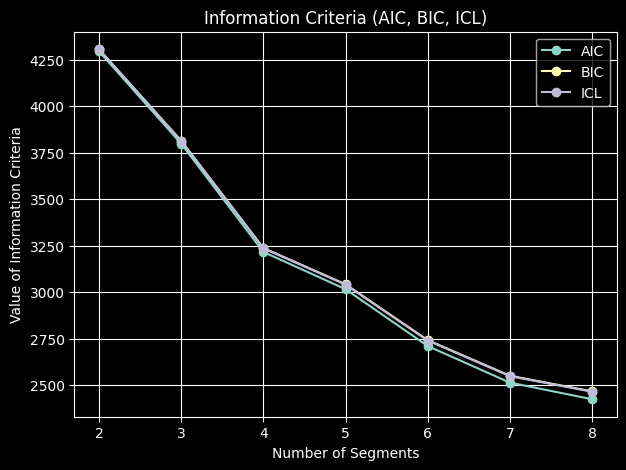

In [99]:

num_segments = MD_mp["k"]
AIC_values = MD_mp["AIC"]
BIC_values = MD_mp["BIC"]
ICL_values = MD_mp["ICL"]

plt.plot(num_segments, AIC_values, marker='o', label='AIC')
plt.plot(num_segments, BIC_values, marker='o', label='BIC')
plt.plot(num_segments, ICL_values, marker='o', label='ICL')

plt.xlabel('Number of Segments')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL)')
plt.legend()
plt.grid(True)

plt.show()

In [100]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import pandas as pd

num_clusters = 4

kmeans_model = KMeans(n_clusters=num_clusters, random_state=1234)
kmeans_model.fit(MD_x)
kmeans_assignments = kmeans_model.predict(MD_x)

# Fitting the  Gaussian Mixture Model and predicting  clusters
gmm_model = GaussianMixture(n_components=num_clusters, random_state=1234)
gmm_model.fit(MD_x)
gmm_assignments = gmm_model.predict(MD_x)

cluster_results = pd.DataFrame({'KMeans': kmeans_assignments, 'GMM': gmm_assignments})

filtered_data = MD_x[cluster_results['GMM'] == 3]

filtered_kmeans_model = KMeans(n_clusters=num_clusters, random_state=1234)
filtered_kmeans_model.fit(filtered_data)
filtered_kmeans_assignments = filtered_kmeans_model.predict(filtered_data)

filtered_results = pd.DataFrame({'KMeans': filtered_kmeans_assignments, 'GMM': 3})

# Cross-tabulation between KMeans and GMM
cross_tab_1 = pd.crosstab(cluster_results['KMeans'], cluster_results['GMM'])
cross_tab_2 = pd.crosstab(cluster_results['KMeans'], filtered_results['KMeans'])

print("Cross-tabulation Results (KMeans vs. GMM):")
print(cross_tab_1)

print("\nCross-tabulation Results (KMeans vs. KMeans for filtered data):")
print(cross_tab_2)


Cross-tabulation Results (KMeans vs. GMM):
GMM       0    1    2    3
KMeans                    
0       546    0    1   33
1         0  213   11    4
2        46    3  265    8
3        29   38    0  256

Cross-tabulation Results (KMeans vs. KMeans for filtered data):
KMeans   0   1   2   3
KMeans                
0       51  15  35  20
1       18   8  11  11
2       23   9  14  22
3       29   5  15  15


In [101]:
gmm_ma = GaussianMixture(n_components=4)
gmm_ma.fit(MD_x)

log_likelihood_ma = gmm_ma.score(MD_x)

gmm_m = GaussianMixture(n_components=4)
gmm_m.fit(MD_x)

log_likelihood_m = gmm_m.score(MD_x)

print("Log-likelihood for MD_x.ma:", log_likelihood_ma)
print("Log-likelihood for MD_x.m:", log_likelihood_m)

Log-likelihood for MD_x.ma: 9.456781748071885
Log-likelihood for MD_x.m: 3.642746401176581


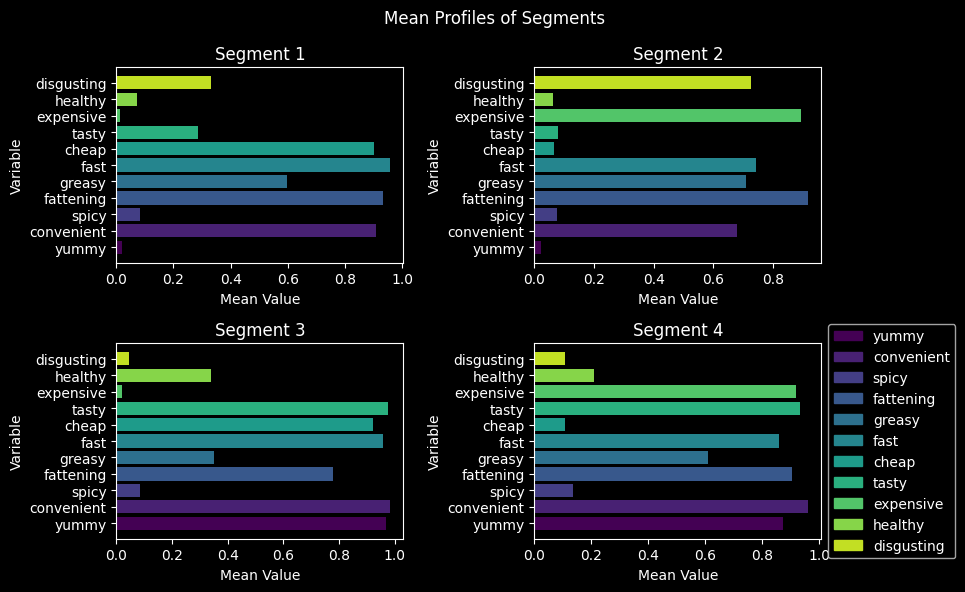

In [102]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  

# Extracting the KMeans model for segment 4
kmeans_model_segment4 = MD_k['4']

# Get labels assigned by the KMeans model
segment_labels = kmeans_model_segment4.labels_

mean_values_per_segment = MD_x.groupby(segment_labels).mean()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))

color_palette = cm.viridis  

# Looping through each segment and plot the mean values
for segment_index in range(mean_values_per_segment.shape[0]):
    num_variables = mean_values_per_segment.shape[1]
    
    for variable_index in range(num_variables):
        color = color_palette(variable_index / num_variables)  
        axes[segment_index // 2, segment_index % 2].barh(variable_index, mean_values_per_segment.iloc[segment_index, variable_index], color=color)

    axes[segment_index // 2, segment_index % 2].set_title(f'Segment {segment_index + 1}')
    axes[segment_index // 2, segment_index % 2].set(ylabel='Variable', xlabel='Mean Value')
    axes[segment_index // 2, segment_index % 2].set_yticks(range(num_variables))
    axes[segment_index // 2, segment_index % 2].set_yticklabels(MD_x.columns)


fig.suptitle('Mean Profiles of Segments')

fig.tight_layout(rect=[0, 0, 0.85, 1])  

legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_palette(i / num_variables)) for i in range(num_variables)]
plt.legend(legend_handles, MD_x.columns, loc='center left', bbox_to_anchor=(1, 0.5))

# Display the plot
plt.show()


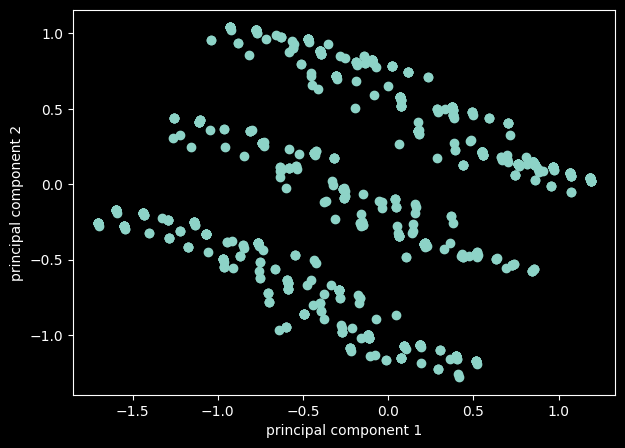

In [103]:

kmeans = KMeans(n_clusters=4)
kmeans.fit(MD_x)

pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

fig, ax = plt.subplots()

ax.scatter(MD_pca[:, 0], MD_pca[:, 1])
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')
plt.show()

In [104]:
# Define a mapping of string values to numeric codes
sentiment_mapping = {
    'I HATE IT!-5': -5,
    '-4': -4,
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'I LOVE IT!+5': 5
}

# Map the 'Like' column to numeric values
mcdonalds['Like.n'] = mcdonalds['Like'].map(sentiment_mapping)

like_n_counts = mcdonalds['Like.n'].value_counts().reset_index()
like_n_counts.columns = ['Numeric Value', 'Count']

print("Numeric Value | Count")
print("-" * 20)
for index, row in like_n_counts.iterrows():
    print(f"{row['Numeric Value']: <15} | {row['Count']}")


Numeric Value | Count
--------------------
0.0             | 169.0
-3.0            | 73.0
-4.0            | 71.0
-2.0            | 59.0
-1.0            | 58.0


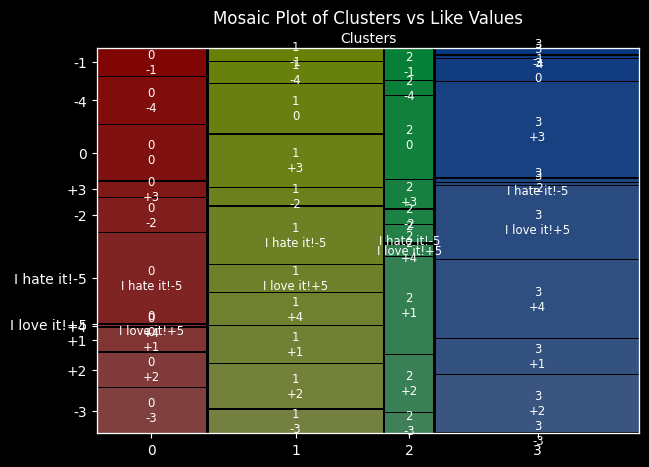

In [105]:
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Label encoding for categorical columns - Converting 11 columns with yes/no
def encode_labels(column):
    mcdonalds[column] = LabelEncoder().fit_transform(mcdonalds[column])
    return mcdonalds

# List of categorical columns to encode
categorical_columns = [
    'yummy', 'convenient', 'spicy', 'fattening', 'greasy',
    'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting'
]

for column in categorical_columns:
    encode_labels(column)

selected_mcdonalds = mcdonalds.loc[:, categorical_columns]

# Fitting KMeans clustering
kmeans_model = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(selected_mcdonalds)
mcdonalds['cluster_label'] = kmeans_model.labels_

unique_like_categories = mcdonalds['Like'].unique()

crosstab_result = pd.crosstab(mcdonalds['cluster_label'], mcdonalds['Like'])

crosstab_result = crosstab_result[unique_like_categories]

# Plotting
plt.rcParams['figure.figsize'] = (7, 5)
mosaic(crosstab_result.stack())
plt.title('Mosaic Plot of Clusters vs Like Values')
plt.xlabel('Clusters')
plt.ylabel('Like Values')
plt.show()


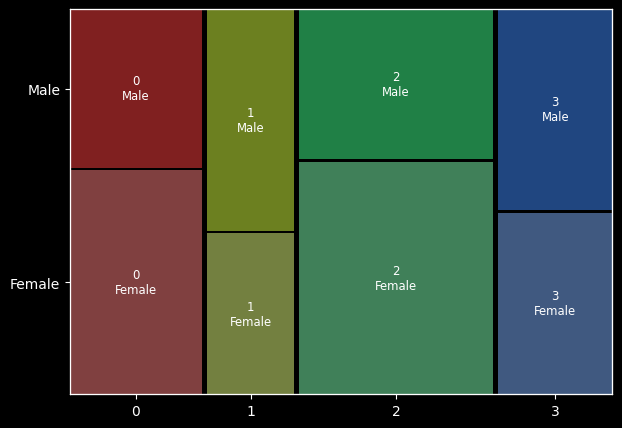

In [106]:
#cross tabulation of segment and gender
MD_k4=MD_k['4']
k4 = MD_k4.labels_

ct = pd.crosstab(k4, mcdonalds['Gender'])
ct
mosaic(ct.stack(),gap=0.01)

plt.show()

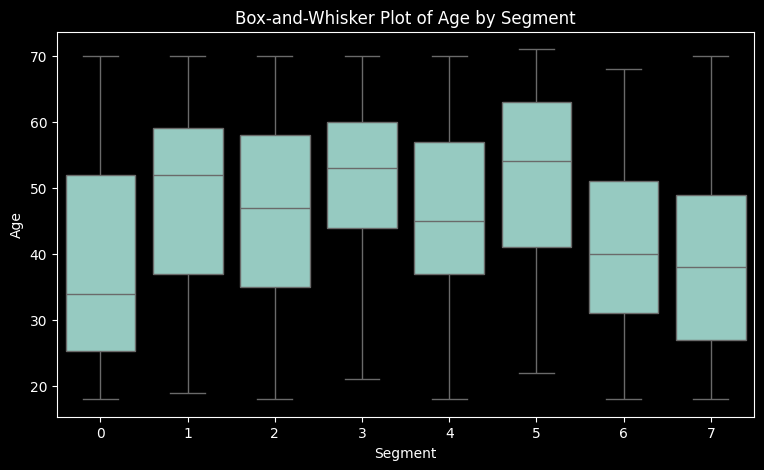

In [107]:
#box and whisker plot for age and segment
data = {
    'segment': labels,
    'Age': mcdonalds.Age
}
dff = pd.DataFrame(data)

plt.figure(figsize=(9, 5))
sns.boxplot(x='segment', y='Age', data=dff)
plt.xlabel('Segment')
plt.ylabel('Age')
plt.title('Box-and-Whisker Plot of Age by Segment')

plt.show()

In [108]:
#grouping 
mcdonalds['VisitFrequency'] = LabelEncoder().fit_transform(mcdonalds['VisitFrequency'])
visit = mcdonalds.groupby('cluster_label')['VisitFrequency'].mean()
visit = visit.to_frame().reset_index()
visit

,cluster_label,VisitFrequency
0,0,2.787162
1,1,2.596195
2,2,2.618321
3,3,2.598553


In [109]:
mcdonalds['Like'] = LabelEncoder().fit_transform(mcdonalds['Like'])
Like = mcdonalds.groupby('cluster_label')['Like'].mean()
Like = Like.to_frame().reset_index()
Like

,cluster_label,Like
0,0,5.888514
1,1,4.957717
2,2,3.694656
3,3,3.915009


In [110]:
mcdonalds['Gender'] = LabelEncoder().fit_transform(mcdonalds['Gender'])
Gender = mcdonalds.groupby('cluster_label')['Gender'].mean()
Gender = Gender.to_frame().reset_index()
Gender

,cluster_label,Gender
0,0,0.432432
1,1,0.547569
2,2,0.427481
3,3,0.401447


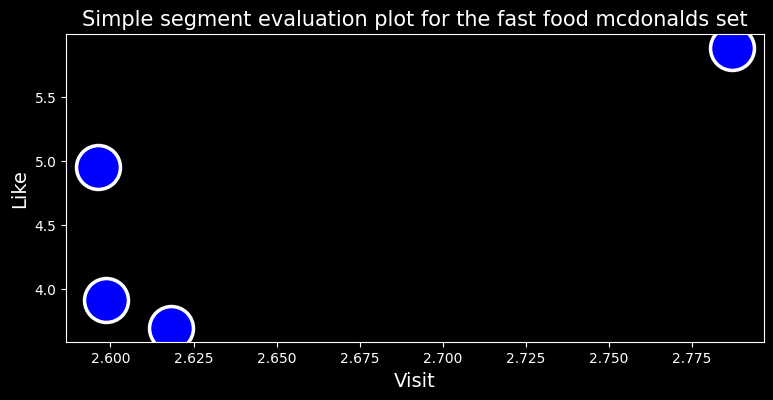

In [111]:
# Scatter Plot for Segment Evaluation
mcdonalds['VisitFrequency'] = LabelEncoder().fit_transform(mcdonalds['VisitFrequency'])
visit = mcdonalds.groupby('cluster_label')['VisitFrequency'].mean().reset_index()
mcdonalds['Like'] = LabelEncoder().fit_transform(mcdonalds['Like'])
Like = mcdonalds.groupby('cluster_label')['Like'].mean().reset_index()
mcdonalds['Gender'] = LabelEncoder().fit_transform(mcdonalds['Gender'])
Gender = mcdonalds.groupby('cluster_label')['Gender'].mean().reset_index()
segment = Gender.merge(Like, on='cluster_label', how='left').merge(visit, on='cluster_label', how='left')
segment
plt.figure(figsize = (9,4))
sns.scatterplot(x = "VisitFrequency", y = "Like",data=segment,s=1000, color="blue")
plt.title("Simple segment evaluation plot for the fast food mcdonalds set",fontsize = 15)
plt.xlabel("Visit", fontsize = 14)
plt.ylabel("Like", fontsize = 14)
plt.show()